# Import Dependencies

In [13]:
import io
import numpy as np
import onnxruntime
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw, ImageFont
from resizeimage import resizeimage
import numpy as np
import pdb
import onnx
%matplotlib inline

# Super Resolution Model Definition in Pytorch

In [14]:
class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

# Load Pretrained Model Weights

In [15]:
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()


print(torch.__version__)

x = torch.randn(1, 1, 224, 224, requires_grad=True)
torch_model.eval()

1.13.0+cpu


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

# Preprocessing Image

In [16]:
orig_img = Image.open('../picture/2.jpg')
img = resizeimage.resize_cover(orig_img, [224,224], validate=False)
img_ycbcr = img.convert('YCbCr')
img_y_0, img_cb, img_cr = img_ycbcr.split()
img_ndarray = np.asarray(img_y_0)

img_4 = np.expand_dims(np.expand_dims(img_ndarray, axis=0), axis=0)
img_5 = img_4.astype(np.float32) / 255.0
img_5

array([[[[0.9764706 , 0.9764706 , 0.9764706 , ..., 0.96862745,
          0.96862745, 0.96862745],
         [0.9764706 , 0.9764706 , 0.9764706 , ..., 0.9647059 ,
          0.9647059 , 0.9647059 ],
         [0.9764706 , 0.9764706 , 0.9764706 , ..., 0.9647059 ,
          0.9647059 , 0.9647059 ],
         ...,
         [0.25882354, 0.25882354, 0.25882354, ..., 0.1882353 ,
          0.17254902, 0.15686275],
         [0.25490198, 0.2509804 , 0.2509804 , ..., 0.16078432,
          0.15294118, 0.15294118],
         [0.25882354, 0.2627451 , 0.27058825, ..., 0.17254902,
          0.17254902, 0.1764706 ]]]], dtype=float32)

# Run Model on Onnxruntime

In [17]:
# Start from ORT 1.10, ORT requires explicitly setting the providers parameter if you want to use execution providers
# other than the default CPU provider (as opposed to the previous behavior of providers getting set/registered by default
# based on the build flags) when instantiating InferenceSession.
# For example, if NVIDIA GPU is available and ORT Python package is built with CUDA, then call API as following:
# onnxruntime.InferenceSession(path/to/model, providers=['CUDAExecutionProvider'])
ort_session = onnxruntime.InferenceSession("../model/super-resolution-10.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: img_5} 
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

# Postprocessing Image

C:\Users\Chn\AppData\Local\Temp\ipykernel_8792\712882747.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_cb.resize(img_out_y.size, Image.BICUBIC),
C:\Users\Chn\AppData\Local\Temp\ipykernel_8792\712882747.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_cr.resize(img_out_y.size, Image.BICUBIC),


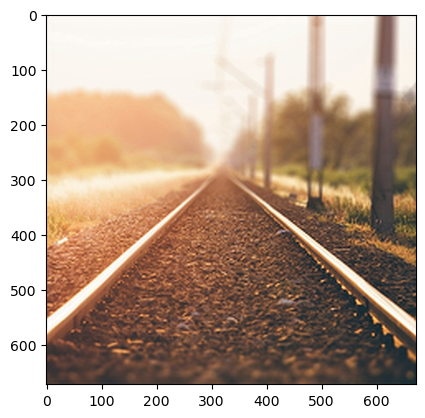

In [18]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')
# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")
plt.imshow(final_img)
